In [98]:
import pathlib as pl
from collections import defaultdict
from configparser import ConfigParser
import itertools as itt

import joblib as jl
import numpy as np
import pandas as pd
from IPython.display import Image
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import pearsonr, linregress, sem, wilcoxon
from sklearn.metrics import r2_score
from nems.db import batch_comp

from src.data.load import get_batch_ids
from src.root_path import config_path
from src.utils.subsets import cellid_A1_fit_set, cellid_PEG_fit_set, batch_map
from src.visualization.palette import *
from src.visualization.interactive import plot_raw_pair
from src.models.modelnames import modelnames as all_modelnames
from src.models.param_tools import get_population_weights, get_strf, get_pop_eg_psth

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))


In [99]:
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220520_minimal_DF'
model_df_file = pl.Path(config['paths']['analysis_cache']) / f'220412_resp_pred_metrics_by_chunks'
working_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220531_fig4_wdf'

recache_wdf = False


if working_DF_file.exists() and not recache_wdf:
    resp_wide = jl.load(working_DF_file)
    print("found and loaded working data fram from cache")
else:
    print('creating working dataframe ...')
    DF_mass = jl.load(summary_DF_file)
    DF = jl.load(model_df_file)

    filter = DF_mass.query(f"mult_comp_corr == 'bf_cp' and source == 'real' and cluster_threshold == 0.05 and "
                       f"metric == 'integral' and value > 0 and " # this line definese what is passed as significant
                       f"id in {list(cellid_A1_fit_set.union(cellid_PEG_fit_set))}"
            ).loc[:, ['id', 'context_pair', 'probe']] # these are the minimum columns to define an individual instance

    resp_wide = pd.merge(filter, DF, on=['id', 'context_pair', 'probe'], validate='1:m')\
    .query("metric in ['integral', 'mass_center']").rename(columns={'resp': 'response'})

    del(DF_mass, DF, filter)
    jl.dump(resp_wide, working_DF_file)
    print('done')

print(resp_wide.shape)
resp_wide.head(10)

found and loaded working data fram from cache
(607040, 12)


,id,context_pair,probe,value,metric,response,modelname,nickname,site,region,stim_count,time_bin
0,TNC016a-56-1,00_02,1,16.245159,integral,34.827586,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC016a,A1,10,A
1,TNC016a-56-1,00_02,1,72.799409,mass_center,124.158416,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC016a,A1,10,A
4,TNC016a-56-1,00_02,1,4.789977,integral,13.103448,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC016a,A1,10,B
5,TNC016a-56-1,00_02,1,367.505815,mass_center,375.526316,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC016a,A1,10,B
8,TNC016a-56-1,00_02,1,1.170461,integral,20.0,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC016a,A1,10,C
9,TNC016a-56-1,00_02,1,583.175578,mass_center,623.793103,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC016a,A1,10,C
12,TNC016a-56-1,00_02,1,4.64041,integral,13.448276,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC016a,A1,10,D
13,TNC016a-56-1,00_02,1,885.666719,mass_center,865.897436,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC016a,A1,10,D
16,TNC016a-56-1,00_02,1,26.846008,integral,81.37931,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC016a,A1,10,full
17,TNC016a-56-1,00_02,1,288.14056,mass_center,410.0,ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-...,matchl_STRF,TNC016a,A1,10,full


In [100]:
working_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220531_fig4_wdf'
jl.dump(resp_wide, working_DF_file)


['/auto/users/mateo/code/context_probe_analysis/data/220531_fig4_wdf']

# Full scatter example panels
in this case for the worst and best model in the two time bins where they diverge

In [101]:
# save all the panels in a convenient dictionary.
panels = defaultdict(list)

A, matchl_STRF, R2=-0.7420101129312067, r=0.4764106264708998, pvalue=0.0
A, matchl_full, R2=-0.16972939961962208, r=0.6111180460529047, pvalue=0.0
B, matchl_STRF, R2=-0.5435122133976757, r=0.43106062146777707, pvalue=0.0
B, matchl_full, R2=0.19370957427775348, r=0.6967301893841072, pvalue=0.0


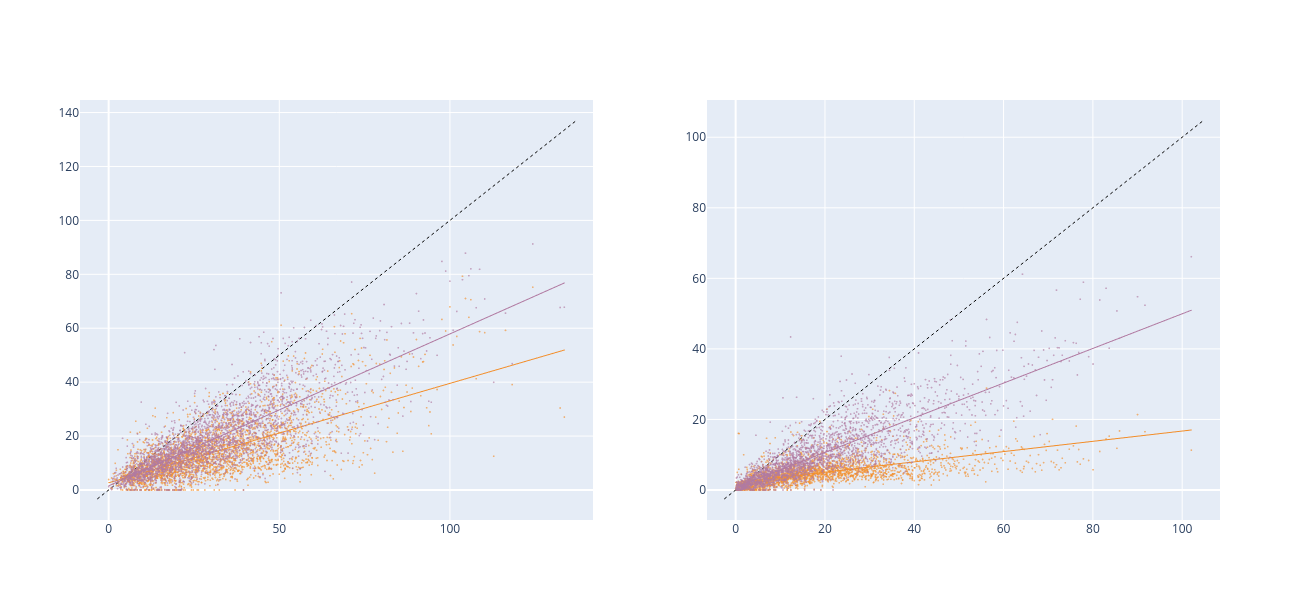

In [126]:
# panels = defaultdict(list)


colormap = {'matchl_STRF': Orange,
            'matchl_self': Blue,
            'matchl_pop': Green,
            'matchl_full': Purple}

decimate = 5000
time_bins = ['A', 'B']
selected = ['matchl_STRF', 'matchl_full']

for cc, tbin in enumerate(time_bins):
    panelname = f'{tbin}_scatter'
    if panelname in panels:
        panels.pop(panelname)

    ranges = list()
    for nn, nknm in enumerate(selected):
        subplotdf = resp_wide.query(f"metric == 'integral' and time_bin == '{tbin}' and  nickname == '{nknm}'")

        x = subplotdf.response.values.astype(float)
        y = subplotdf.value.values.astype(float)
        R2 = r2_score(x, y)
        slope, bias, r, pval, _ = linregress(x, y)
        print(f"{tbin}, {nknm}, R2={R2}, r={r}, pvalue={pval}")

        # # plots a fraction of the raw data
        # rndsmp = np.random.random_sample(size=x.shape) < 0.2 # subsamples 20% of the data
        # panels[panelname].append(go.Scattergl(x=x[rndsmp], y=y[rndsmp], mode='markers',
        #                            opacity=0.3,
        #                            marker=dict(opacity=0.5,
        #                                        size=3,
        #                                        color=colormap[nknm],
        #                                        line_color='black'),
        #                            showlegend=False,
        #                            hoverinfo='skip')
        #                          )

        # decimated trend line
        srtidx = np.argsort(x)
        x = x[srtidx]
        y = y[srtidx]
        qntils = np.quantile(x, np.linspace(0, 1, decimate + 1), interpolation='higher')
        xm = np.empty((decimate))
        ym = np.empty((decimate))
        for rr in range(len(qntils) - 1):
            if rr == 0:
                mask = (x <= qntils[rr + 1])
            else:
                mask = (qntils[rr] < x) & (x <= qntils[rr + 1])

            if mask.sum() == 0:
                xm[rr] = np.nan
                ym[rr] = np.nan
            else:
                xm[rr] = np.mean(x[mask])
                ym[rr] = np.mean(y[mask])

        panels[panelname].append(
            go.Scattergl(x=xm, y=ym, mode='markers',
                         opacity=0.8,
                         marker=dict(
                             opacity=0.8,
                             color=colormap[nknm],
                             size=2
                         ),
                         name=f'{nknm}',
                         hoverinfo='skip', showlegend=False
                         )
        )

        model_range = [np.nanmin(np.stack([xm, ym])),
                       np.nanmax(np.stack([xm, ym]))]

        # regression lines
        panels[panelname].append(
            go.Scattergl(x=model_range,
                         y=np.asarray(model_range)*slope+bias,
                         mode='lines',
                         line=dict(
                             color=colormap[nknm],
                             width=1
                         ),
                         opacity=1,
                         name=f'{nknm}',
                         hoverinfo='skip',
                         showlegend=False
                         )
        )

        ranges.append(model_range)

    # unity line
    ranges = np.stack(ranges, axis=1)
    plot_range = [ranges[0, :].min(), ranges[1, :].max()]
    plot_range = [plot_range[0] - (np.diff(plot_range)[0] * 0.025),
                  plot_range[1] + (np.diff(plot_range)[0] * 0.025)]

    panels[panelname].append(go.Scatter(x=plot_range, y=plot_range, mode='lines',
                                        line=dict(color='black',
                                                  dash='dot',
                                                  width=1),
                                        showlegend=False)
                             )

# test plotting please ignore
fig = make_subplots(rows=1, cols=len(time_bins))
for tt, tbin in enumerate(time_bins):
    panel = panels[f'{tbin}_scatter']
    fig.add_traces(panel, rows=[1] * len(panel), cols=[tt + 1] * len(panel))

# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=600)
Image(img_bytes)

# bars summarizing the rest of models and time bins

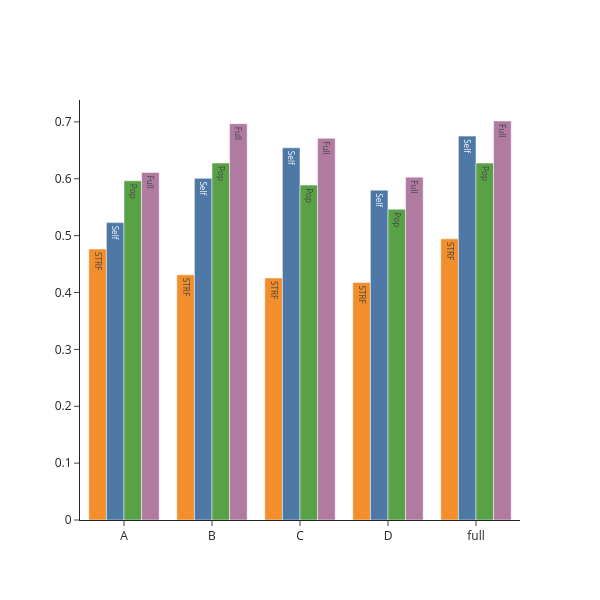

In [123]:
# panels = defaultdict(list)

# calculates pearsons correlation and R2 between real and predicted integral values, for all combinations of models
# and time bin chunks
to_regress = resp_wide.query(f"metric == 'integral'").loc[:, ['time_bin', 'nickname', 'response', 'value']]
reg_df = to_regress.groupby(['time_bin', 'nickname']).apply(lambda x: pearsonr(x['response'], x['value'])).reset_index()
reg_df[['pearsonsr', 'pvalue']] = pd.DataFrame(reg_df[0].tolist(), index=reg_df.index)
reg_df.drop(columns=[0], inplace=True)

det_df = to_regress.groupby(['time_bin', 'nickname']).apply(lambda x: r2_score(x['response'], x['value']))
det_df.name = 'R2'

display_name_map = {'matchl_STRF': 'STRF',
                    'matchl_self': 'Self',
                    'matchl_pop': 'Pop',
                    'matchl_full': 'Full'}
toplot = pd.merge(reg_df, det_df, on=['time_bin', 'nickname'], validate='1:1')
toplot['display_name'] = toplot.nickname.apply(lambda x: display_name_map[x])
toplot

# creates and stores panel
bars = px.bar(data_frame=toplot, x='time_bin', y='pearsonsr',
                                   color='nickname',
                                   barmode='group',
                                   custom_data=['pvalue'], text='display_name',
                                   category_orders={'time_bin': ['full', 'A', 'B', 'C', 'D'],
                                                    'nickname': ['matchl_STRF',
                                                                 'matchl_self',
                                                                 'matchl_pop',
                                                                 'matchl_full']},
                                   color_discrete_map=colormap,
                                   )['data']

# test plotting please ignore
if 'metric_reg_bars' in panels:
    panels.pop('metric_reg_bars')
panels['metric_reg_bars'].extend(bars)

panel = panels['metric_reg_bars']
fig = go.Figure().add_traces(panel)
fig.update_layout(showlegend=False, template='simple_white')
# fig.show()
img_bytes = fig.to_image(format="png", width=600, height=600)
Image(img_bytes)

# General model fitness
this is a usefull plot that should be refactored into interactive

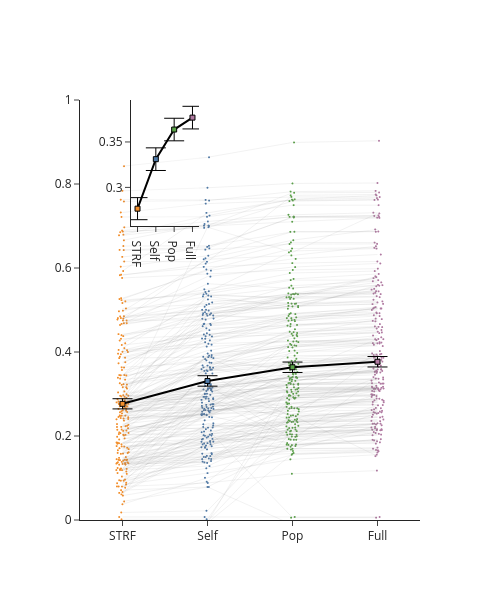

In [119]:
# panels = defaultdict(list)

stat = 'r_test'
cellids = cellid_A1_fit_set.union(cellid_PEG_fit_set)
nicknames = ['matchl_STRF', 'matchl_self', 'matchl_pop', 'matchl_full']
modelnames = [mod for key, mod in all_modelnames.items() if key in nicknames]

DF = batch_comp(batch=[326, 327], modelnames=modelnames, cellids=cellids, stat=stat)

display_names = [display_name_map[nknm] for nknm in nicknames]
DF.columns = display_names

DF.reset_index(inplace=True)

# add region information, is this really needed??
A1df = get_batch_ids(326)
A1df['region'] = 'A1'
PEGdf = get_batch_ids(327)
PEGdf['region'] = 'PEG'
regdf = pd.concat([A1df, PEGdf])

wide = pd.merge(DF, regdf, on='cellid').rename(columns={'cellid': 'id', 'siteid': 'site'})
toplot = pd.melt(wide, id_vars=['id', 'site', 'region'], value_vars=display_names, var_name='model', value_name=stat)



# creates and stores panels
# single lines grayed out
single_lines = list()
for ll in wide.loc[:, display_names].values:
    single_lines.append(
        go.Scatter(x=display_names, y=ll,
                   mode='lines',
                   opacity=0.1,
                   line=dict(
                       color='gray',
                       width=1
                   ),
                   showlegend=False
                   )
    )

# mean and SEM line
mean = wide.loc[:, display_names].values.mean(axis=0)
err = sem(wide.loc[:, display_names].values, axis=0)
mean_line =     go.Scatter(x=display_names, y=mean,
               mode='lines',
               opacity=1,
               showlegend=False,
               line=dict(color='black'
                         )
               )


# mean and SEM markers
mean_markers = go.Scatter(x=display_names, y=mean,
               mode='markers',
               opacity=1,
               showlegend=False,
               marker=dict(color=[colormap[nknm] for nknm in nicknames],
                           symbol='square',
                           size=5,
                           line=dict(color='black',
                                     width=1)
                           ),
               error_y=dict(array=err,
                            color='black',
                            thickness=1,
                            width = 10
                            )
               )



# individual dots
strip = px.strip(toplot, y=stat, x='model', color='model',
                                        color_discrete_map={display_name_map[nknm]: clr for nknm, clr in
                                                            colormap.items()},

                                        )
strip = strip.update_traces(marker=dict(opacity=1,
                                size=2)
                    )['data']


if 'model_fitness' in panels:
    panels.pop('model_fitness')
if 'model_fitness_summary' in panels:
    panels.pop('model_fitness_summary')

panels['model_fitness'].extend(single_lines)
panels['model_fitness'].extend(strip)
panels['model_fitness'].append(mean_line)
panels['model_fitness'].append(mean_markers)

panels['model_fitness_summary'].append(mean_line)
panels['model_fitness_summary'].append(mean_markers)

# test plotting please ignore
panel1 = panels['model_fitness']
panel2 = panels['model_fitness_summary']
fig = make_subplots(cols=1,rows=2,shared_xaxes=False)
fig.add_traces(panel1, cols=[1]*len(panel1), rows=[1]*len(panel1))
fig.add_traces(panel2, cols=[1]*len(panel2), rows=[2]*len(panel2))
fig.update_layout(showlegend=False, template='simple_white',
                  xaxis1=dict(domain=[0, 1], anchor='y1'),
                  yaxis1=dict(domain=[0, 1], anchor='x1',
                              range=[0,1]),
                  xaxis2=dict(domain=[0.15, 0.35], anchor='y2'),
                  yaxis2=dict(domain=[0.7, 1], anchor='x2'),
                  plot_bgcolor='rgba(256,256,256,0.2)') # background color changes for all subplots,
                                                        # but is only relevant and visible for the inset!
# fig.show()
img_bytes = fig.to_image(format="png", width=500, height=600)
Image(img_bytes)

In [105]:
for m0,m1 in itt.combinations(display_names, r=2):
    out = wilcoxon(wide[m0], wide[m1])
    print(f'Wilcoxon: {m0}vs{m1}, pvalue={out.pvalue}')


Wilcoxon: STRFvsSelf, pvalue=5.0753167687428426e-39
Wilcoxon: STRFvsPop, pvalue=3.5171423551002404e-37
Wilcoxon: STRFvsFull, pvalue=7.449166710711646e-37
Wilcoxon: SelfvsPop, pvalue=2.7508302854312496e-24
Wilcoxon: SelfvsFull, pvalue=2.0663645993695604e-35
Wilcoxon: PopvsFull, pvalue=3.1746520868200875e-34


# example model fits

enforcing model raster_fs
enforcing model raster_fs


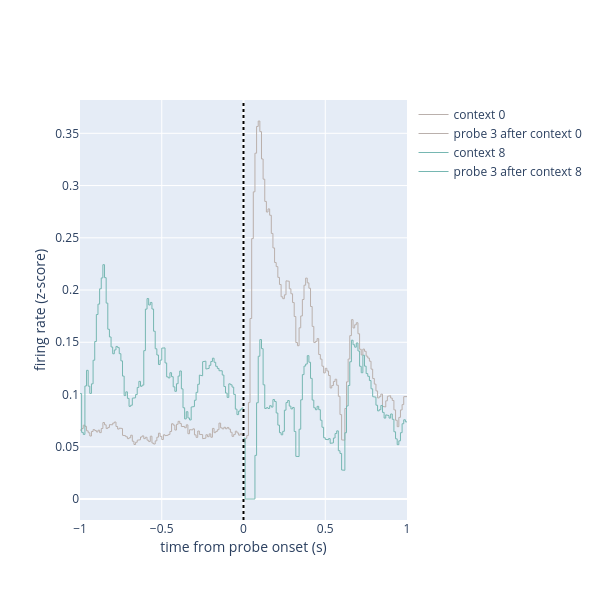

In [115]:
selected = ['matchl_STRF', 'matchl_full']
eg_cellid, eg_contexts, eg_probe= 'TNC014a-22-2', (8, 10), 8

STRF_eg = plot_raw_pair(eg_cellid, (0, 8), 3, modelname=all_modelnames[selected[0]], batch=batch_map[eg_cellid])
STRF_eg.update_traces(line_width=1)
full_eg = plot_raw_pair(eg_cellid, (0, 8), 3, modelname=all_modelnames[selected[1]], batch=batch_map[eg_cellid])
full_eg.update_traces(line_width=1)

if 'STRF_eg' in panels:
    panels.pop('STRF_eg')
if 'full_eg' in panels:
    panels.pop('full_eg')
panels["STRF_eg"] = STRF_eg['data']
panels["full_eg"] = full_eg['data']


img_bytes = full_eg.to_image(format="png", width=600, height=600)
Image(img_bytes)

enforcing model raster_fs
enforcing model raster_fs
enforcing model raster_fs
enforcing model raster_fs


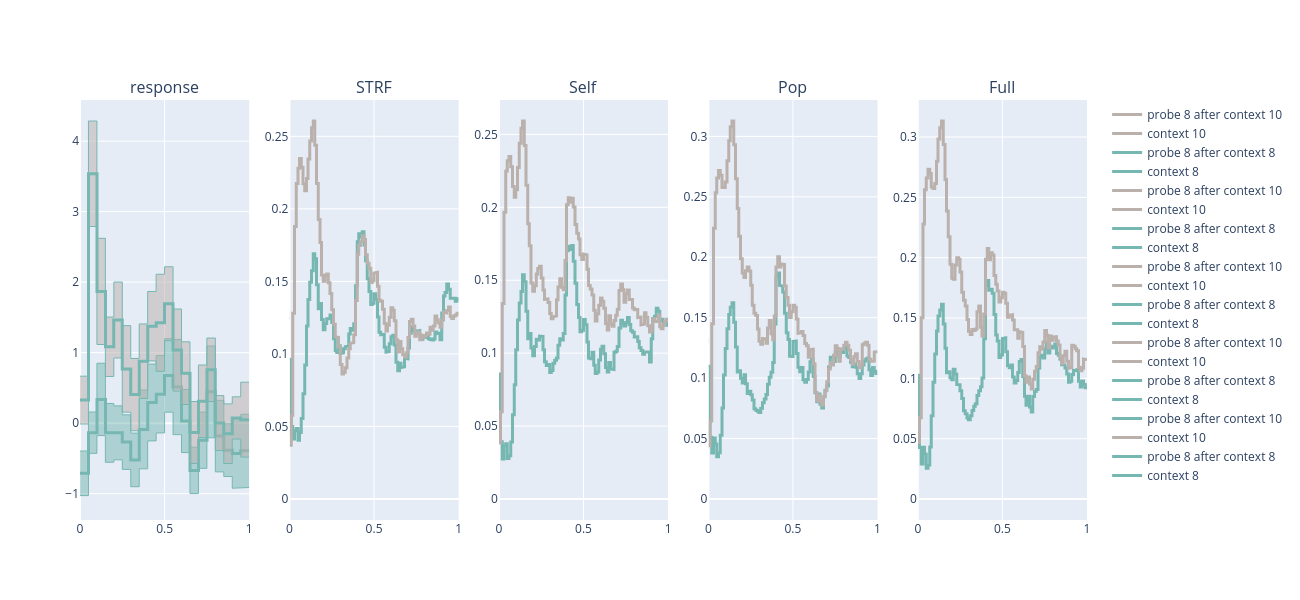

In [107]:
fig = make_subplots(rows=1, cols=len(nicknames)+1, shared_yaxes=False,
                    subplot_titles=['response'] + [display_name_map[nknm] for nknm in nicknames])

eg_cellid, eg_contexts, eg_probe= 'TNC014a-22-2', (8, 10), 8

pan = plot_raw_pair(eg_cellid, eg_contexts, eg_probe, raster_fs=20)['data']
fig.add_traces(pan, cols=[1]*len(pan), rows=[1]*len(pan))

for cc, nknm in enumerate(nicknames):
    pan = plot_raw_pair(eg_cellid, eg_contexts, eg_probe, modelname=all_modelnames[nknm], batch=batch_map[eg_cellid])['data']
    fig.add_traces(pan, cols=[cc+2]*len(pan), rows=[1]*len(pan))
fig.update_xaxes(range=[0,1])
# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=600)
Image(img_bytes)

# Model schematic

In [108]:
eg_cellid, eg_contexts, eg_probe= 'TNC014a-22-2', (8, 10), 8
eg_ctx = 10,
eg_prb = eg_probe - 1
eg_modelname = all_modelnames['matchl_full']

# get filters
pop_weight = get_population_weights(eg_cellid, batch_map[eg_cellid], eg_modelname)
strf = get_strf(eg_cellid, batch_map[eg_cellid], eg_modelname)

# get psths
resp_raster, pop_raster = get_pop_eg_psth(eg_cellid, batch_map[eg_cellid], eg_modelname, part='all')

resp_raster = resp_raster[0, 0, eg_ctx, eg_prb, :].squeeze()
pop_raster = pop_raster[0, :, eg_ctx, eg_prb, :].squeeze()


[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/326/TNC014a-22-2/ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-shfcat.i.resp.state.o.state.mm-dli...2230766671832489790 ...
[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/326/TNC014a-22-2/ozgf.fs100.ch18-ld.popstate-epcpn.seq-avgreps-shfcat.i.resp.state.o.state.mm-dli...2230766671832489790 ...


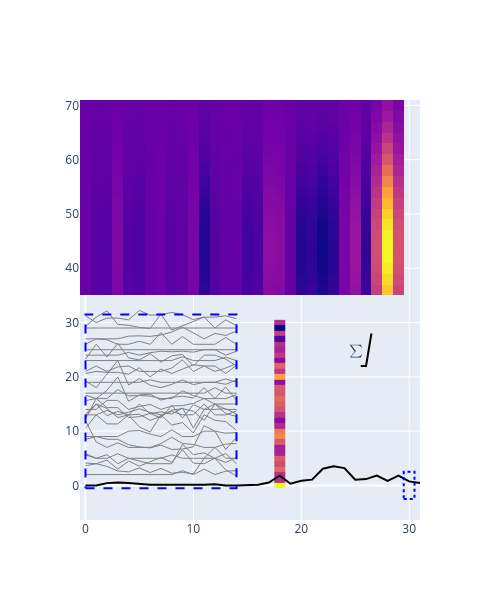

In [121]:
limit_pop = 30
psth_scaling = 5
psth_start = 100 - 15 # half the strf on the probe
extra_resp = 2 # how much the response protrudes from the STRF. min 1


if limit_pop:
    pop_to_plot = pop_raster[:limit_pop,:]
    weights_to_plot = pop_weight[:limit_pop+1]
else:
    pop_to_plot = pop_raster
    weights_to_plot = pop_weight

n_pshts = pop_to_plot.shape[0] + 1

fig = go.Figure()
for ll, cellpsth in enumerate(pop_to_plot):
    cellpsth = cellpsth[psth_start:psth_start+int(strf.shape[1]/2)] * psth_scaling + ll + 1
    x=np.linspace(0,cellpsth.shape[0], int(strf.shape[1]/2), endpoint=False)

    fig.add_trace(
        go.Scatter(x=x, y=cellpsth,
                   mode='lines',
                   opacity=1,
                   line=dict(
                       color='gray',
                       width=1
                   ),
                   showlegend=False
                   )
    )


resp_psth = resp_raster[psth_start:psth_start+strf.shape[1]+extra_resp] * psth_scaling
x=np.linspace(0,resp_psth.shape[0], strf.shape[1]+extra_resp, endpoint=False)
fig.add_trace(
    go.Scatter(x=x, y=resp_psth,
               mode='lines',
               opacity=1,
               line=dict(
                   color='black',
                   width=2
               ),
               showlegend=False
               )
)

fig.add_trace(go.Heatmap(z=strf[:,::-1],
                         y0=n_pshts + 5 , dy=2,
                         showscale=False)
              )
fig.add_trace(go.Heatmap(z=weights_to_plot[:,None],
                         x0=18, dx=1,
                         y0=0, dy=1,
                         showscale=False)
              )

# box around scatter plot
x = np.array([0, int(strf.shape[1]/2)-1, int(strf.shape[1]/2)-1, 0, 0])
y = np.array([0, 0, n_pshts+1, n_pshts+1, 0]) -0.5
fig.add_trace(go.Scatter(x=x,
                         y=y,
                         mode='lines',
                         line=dict(color='blue',
                                   dash='dash'),
                         showlegend=False
                         )
              )


# box around value to predict
x = (np.array([0,1,1,0,0])-0.5) * 1 + 30
y = (np.array([0,0,1,1,0])-0.5) * 5 + 0
fig.add_trace(go.Scatter(x=x,
                         y=y,
                         mode='lines',
                         line=dict(color='blue',
                                   dash='dot'),
                         showlegend=False
                         )
              )

#

# add extra in place symbols
fig.add_trace(go.Scatter(x=[25], y =[25],
                         text=[f'$\sum$'],
                         mode='text',
                         showlegend=False)
              )

# relu
x = np.array([-1,0,1]) * 0.5 + 26
y = np.array([-0.5,-0.5,0.5]) * 6 + 25
fig.add_trace(go.Scatter(x=x, y=y,
                         mode='lines',
                         line=dict(color='black',
                                   width=2),
                         showlegend=False)
              )


if 'model_cartoon' in panels:
    panels.pop('model_cartoon')

panels['model_cartoon'].extend(fig['data'])

# fig.show()
img_bytes = fig.to_image(format="png", width=500, height=600)
Image(img_bytes)

# plot pannels

In [111]:
# simple plot layout and other figurewide configurations
def define_subplots():
    fig = make_subplots(rows=3,cols=3, vertical_spacing=0.05, horizontal_spacing=0.05,
                        column_widths=[1/3, 1/3, 1/3], row_heights=[1/2, 1/4, 1/4],
                        specs=[[{'colspan':2}, None, {}           ],
                               [{}           , {}  , {'rowspan':2}],
                               [{}           , {}  , None         ]])
    # figure size in inches at different PPIs

    ppi = 300 # high quality print standard (do i need this if I do postprocecing in vectors)
    ppi = 96 # www standard
    ppi = 92.5 # house monitor

    heigh = 6
    width = 6 # in inches
    _ = fig.update_layout(template='simple_white',
                          margin=dict(l=10, r=10, t=10, b=10),
                          width=round(ppi*width), height=round(ppi*heigh),

                          # model fitness
                          yaxis2=dict(
                              title_text='r-test'
                          ),

                          # example PSTHs
                          xaxis3=dict(matches='x6',showticklabels=False),
                          yaxis3=dict(matches='y6',showticklabels=True),

                          xaxis6=dict(range=[0,1],showticklabels=True),
                          yaxis6=dict(range=[-0.01,0.4],showticklabels=True),

                          # xaxis4=dict(matches='x7',showticklabels=False),
                          # yaxis4=dict(matches='y3',showticklabels=False),
                          # yaxis7=dict(matches='y6',showticklabels=False),

                          xaxis8=dict(anchor='y8', domain=[0.75,0.8]),
                          yaxis8=dict(anchor='x8', domain=[0.85,0.95]),
                          showlegend=False)

    # # scatter x y formating
    # _ = fig.update_xaxes(title=dict(text='duration (ms)', standoff=0, font_color=Purple),
    #                      row=1, col=1)
    # _ = fig.update_yaxes(title=dict(text="amplitude (d'*ms)", standoff=0, font_color=Green),
    #                      row=1, col=1)
    #
    #
    # # x and y from cumulative histograms # todo make common anotation
    # _ = fig.update_xaxes(title=dict(text='amplitude', font_color=Green, standoff=0),
    #                      row=1, col=2)
    # _ = fig.update_xaxes(title=dict(text='duration', font_color=Purple, standoff=0),
    #                      row=2, col=2)
    #
    # _ = fig.update_yaxes(title=dict(text='proportion', standoff=0),
    #                      row=1, col=2)
    # _ = fig.update_yaxes(title=dict(text='proportion', standoff=0),
    #                      row=2, col=2)
    #
    #
    # # y axes formating on the leftmost quantification plot
    # _ = fig.update_yaxes(title=dict(text='amplitude', font_color=Green, standoff=0),
    #                      row=1, col=3)
    # _ = fig.update_yaxes(title=dict(text='duration', font_color=Purple, standoff=0),
    #                      row=2, col=3)
    #
    # # x axes formating on the bottom quantification plot
    # _ = fig.update_xaxes(title=dict(text='context type pair', standoff=0), tickangle=-45,
    #                      row=2, col=3)
    # _ = fig.update_xaxes(title=dict(text='region', standoff=39),
    #                      row=2, col=4)

    return fig, round(ppi*width), round(ppi*heigh)

f, _, _ = define_subplots()
f.print_grid()
# f.show()

This is the format of your plot grid:
[ (1,1) x,y             -      ]  [ (1,3) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]  ⎡ (2,3) x5,y5 ⎤
[ (3,1) x6,y6 ]  [ (3,2) x7,y7 ]  ⎣      :      ⎦



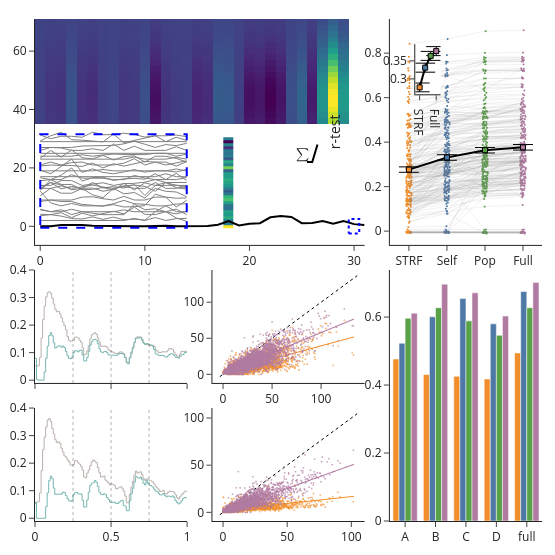

In [127]:
fig, pw, ph  = define_subplots()

# model schematic
pan = panels['model_cartoon']
fig.add_traces(pan, rows=[1]*len(pan), cols=[1]*len(pan))


# full scatter fitness
pan = panels['model_fitness']
fig.add_traces(pan, rows=[1]*len(pan), cols=[3]*len(pan))

# summary inset
pan = panels['model_fitness_summary']
for trace in pan:
    trace.update(xaxis='x8', yaxis='y8')
fig.add_traces(pan)

# example PSTHs
# STRF
pan = panels['STRF_eg']
fig.add_traces(pan, rows=[2]*len(pan), cols=[1]*len(pan))
for vline in [ 0.25, 0.5, 0.75]:
    fig.add_vline(x=vline,line=dict(width=1, dash='dot', color='black'), row=2, col=1)
# full model
pan = panels['full_eg']
fig.add_traces(pan, rows=[3]*len(pan), cols=[1]*len(pan))
for vline in [ 0.25, 0.5, 0.75]:
    fig.add_vline(x=vline,line=dict(width=1, dash='dot', color='black'), row=3, col=1)


# add e.g. model difference prediction scatters This is confusing
pan = panels['A_scatter']
fig.add_traces(pan, rows=[2]*len(pan), cols=[2]*len(pan))

pan = panels['B_scatter']
fig.add_traces(pan, rows=[3]*len(pan), cols=[2]*len(pan))

# summary for difference prediction for all models
pan = panels['metric_reg_bars']
fig.add_traces(pan, rows=[2]*len(pan), cols=[3]*len(pan))


# fig.show()
img_bytes = fig.to_image(format="png", width=pw, height=ph)
Image(img_bytes)